In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ismailnasri20_driver_drowsiness_dataset_ddd_path = kagglehub.dataset_download('ismailnasri20/driver-drowsiness-dataset-ddd')

print('Data source import complete.')

100%|██████████| 2.58G/2.58G [00:39<00:00, 69.8MB/s]

Extracting files...


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**Dataset Preparation and Splitting**

This code loads the driver drowsiness image dataset, extracts image paths, and splits the data into Training, Validation, and Test sets. It then further divides the Training and Validation sets into five smaller subsets.

In [3]:

main_path = ismailnasri20_driver_drowsiness_dataset_ddd_path + '/Driver Drowsiness Dataset (DDD)/'


drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

all_dirs = drowsy_paths + non_drowsy_paths
random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

num_splits = 5
train_split_size = len(train_paths) // num_splits
val_split_size = len(val_paths) // num_splits


train_splits = [train_paths[i * train_split_size:(i + 1) * train_split_size] for i in range(num_splits)]


val_splits = [val_paths[i * val_split_size:(i + 1) * val_split_size] for i in range(num_splits)]

# چاپ اطلاعات
print(f"Total images: {total_size}")
print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")
print(f"\nTraining splits ({num_splits} parts):")

for i, split in enumerate(train_splits):
    print(f"Training Split {i + 1}: {len(split)} images")

print(f"\nValidation splits ({num_splits} parts):")

for i, split in enumerate(val_splits):
    print(f"Validation Split {i + 1}: {len(split)} images")


Total images: 41793
Training set: 29255 images
Validation set: 8358 images
Test set: 4180 images

Training splits (5 parts):
Training Split 1: 5851 images
Training Split 2: 5851 images
Training Split 3: 5851 images
Training Split 4: 5851 images
Training Split 5: 5851 images

Validation splits (5 parts):
Validation Split 1: 1671 images
Validation Split 2: 1671 images
Validation Split 3: 1671 images
Validation Split 4: 1671 images
Validation Split 5: 1671 images


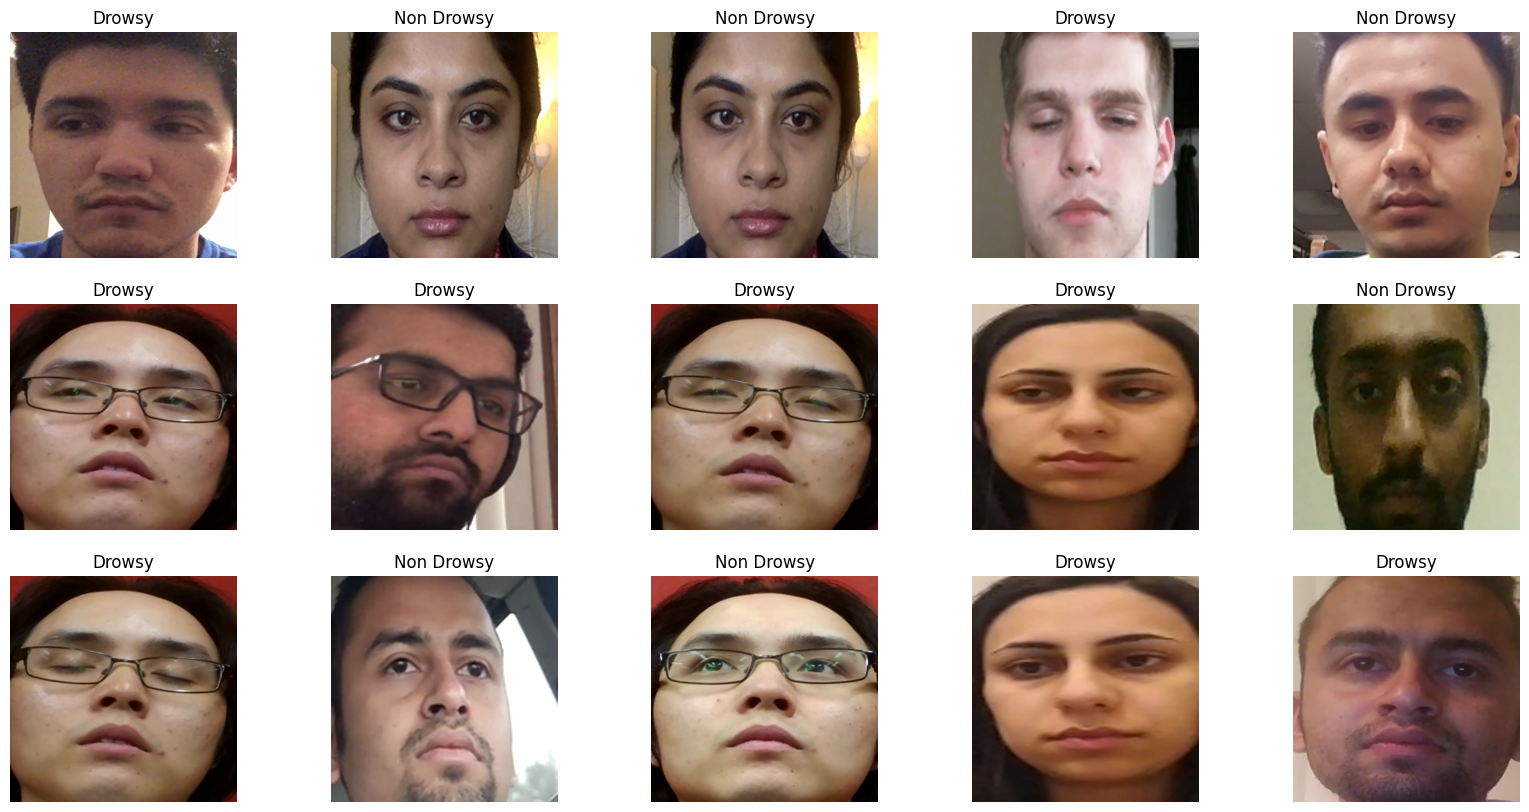

In [4]:
def extract_class_name(p):
    return p.split('/')[-2]
def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)

**Device Selection (GPU/CPU)**

In [5]:
if torch.cuda.is_available():
    dev = device = torch.device("cuda:0")
    print("Run on GPU")
else:
    dev = device = torch.device("cpu")
    print("Run on CPU")

Run on GPU


In [6]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):

        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.extract_class_name(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    @staticmethod
    def extract_class_name(img_path):
        if 'Non Drowsy' in img_path:
            return 1
        elif 'Drowsy' in img_path:

            return 0
        else:
            raise ValueError(f"Undefined class name in path: {img_path}")


**Define data augmentation and transformations**

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_loaders = []
val_loaders = []

batch_size = 64


for fold in range(num_splits):

    train_dataset = MyDataset(train_splits[fold], transform=train_transform)
    val_dataset = MyDataset(val_splits[fold], transform=test_val_transform)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

test_dataset = MyDataset(test_paths, transform=test_val_transform)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

for i, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    print(f"Fold {i + 1}:")
    print(f"Training Loader - Batches: {len(train_loader)}, Samples: {len(train_loader.dataset)}")
    print(f"Validation Loader - Batches: {len(val_loader)}, Samples: {len(val_loader.dataset)}")

print(f"\nTest Loader - Batches: {len(test_loader)}, Samples: {len(test_loader.dataset)}")


Fold 1:
Training Loader - Batches: 92, Samples: 5851
Validation Loader - Batches: 27, Samples: 1671
Fold 2:
Training Loader - Batches: 92, Samples: 5851
Validation Loader - Batches: 27, Samples: 1671
Fold 3:
Training Loader - Batches: 92, Samples: 5851
Validation Loader - Batches: 27, Samples: 1671
Fold 4:
Training Loader - Batches: 92, Samples: 5851
Validation Loader - Batches: 27, Samples: 1671
Fold 5:
Training Loader - Batches: 92, Samples: 5851
Validation Loader - Batches: 27, Samples: 1671

Test Loader - Batches: 66, Samples: 4180


**Simple CNN Model for Image Classification**

This model is a simple convolutional neural network (SimpleCNN) designed for image classification.

Feature Extractor: Consists of two Conv2D layers for extracting image features, each followed by ReLU activation and MaxPooling to reduce spatial dimensions.

Classifier: Includes a Flatten layer to convert extracted features into a vector, a fully connected (Linear) layer with 128 neurons, Dropout to prevent overfitting, and a final output layer for class prediction.

Forward Function: Passes the input through the feature extraction layers and then through the classifier for final predictions.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

**Train model**

In [9]:
def train_individual_models(models_list, train_loaders, val_loaders, criterion, device, optimizer_list, num_epochs=1):
    train_losses = [[] for _ in range(len(models_list))]
    val_losses = [[] for _ in range(len(models_list))]

    for model_idx, (model, optimizer, train_loader, val_loader) in enumerate(zip(models_list, optimizer_list, train_loaders, val_loaders)):
        print(f"Training model {model_idx + 1}...")

        for epoch in range(num_epochs):
            model.train()
            running_train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()

            avg_train_loss = running_train_loss / len(train_loader)
            train_losses[model_idx].append(avg_train_loss)

            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_losses[model_idx].append(avg_val_loss)

            print(f"Model {model_idx + 1}, Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

def ensemble_predict(models_list, val_loaders, device):

    all_predictions = []

    for model_idx, (model, val_loader) in enumerate(zip(models_list, val_loaders)):
        print(f"Predicting with model {model_idx + 1}...")
        model.eval()
        predictions = []

        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                predictions.append(outputs)

        all_predictions.append(torch.cat(predictions, dim=0))


    avg_predictions = torch.stack(all_predictions).mean(dim=0)
    return torch.argmax(avg_predictions, dim=1)



In [10]:
num_models = num_splits
models_list = [SimpleCNN() for _ in range(num_models)]

models_list = [model.to(dev) for model in models_list]

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer_list = [optim.Adam(model.parameters(), lr=0.001) for model in models_list]

train_losses, val_losses = train_individual_models(models_list, train_loaders,val_loaders, criterion, device, optimizer_list, num_epochs=3)

Training model 1...
Model 1, Epoch [1/3] - Train Loss: 0.6568, Val Loss: 0.0229
Model 1, Epoch [2/3] - Train Loss: 0.0211, Val Loss: 0.0086
Model 1, Epoch [3/3] - Train Loss: 0.0080, Val Loss: 0.0100
Training model 2...
Model 2, Epoch [1/3] - Train Loss: 0.3784, Val Loss: 0.0139
Model 2, Epoch [2/3] - Train Loss: 0.0238, Val Loss: 0.0063
Model 2, Epoch [3/3] - Train Loss: 0.0088, Val Loss: 0.0040
Training model 3...
Model 3, Epoch [1/3] - Train Loss: 0.6522, Val Loss: 0.0222
Model 3, Epoch [2/3] - Train Loss: 0.0165, Val Loss: 0.0058
Model 3, Epoch [3/3] - Train Loss: 0.0066, Val Loss: 0.0064
Training model 4...
Model 4, Epoch [1/3] - Train Loss: 0.4882, Val Loss: 0.0118
Model 4, Epoch [2/3] - Train Loss: 0.0211, Val Loss: 0.0071
Model 4, Epoch [3/3] - Train Loss: 0.0146, Val Loss: 0.0032
Training model 5...
Model 5, Epoch [1/3] - Train Loss: 0.4151, Val Loss: 0.0106
Model 5, Epoch [2/3] - Train Loss: 0.0135, Val Loss: 0.0085
Model 5, Epoch [3/3] - Train Loss: 0.0064, Val Loss: 0.0052


In [12]:
ensemble_predictions = ensemble_predict(models_list, val_loaders, device)
print("Ensemble predictions:", ensemble_predictions)

Predicting with model 1...
Predicting with model 2...
Predicting with model 3...
Predicting with model 4...
Predicting with model 5...
Ensemble predictions: tensor([0, 1, 1,  ..., 0, 0, 0], device='cuda:0')


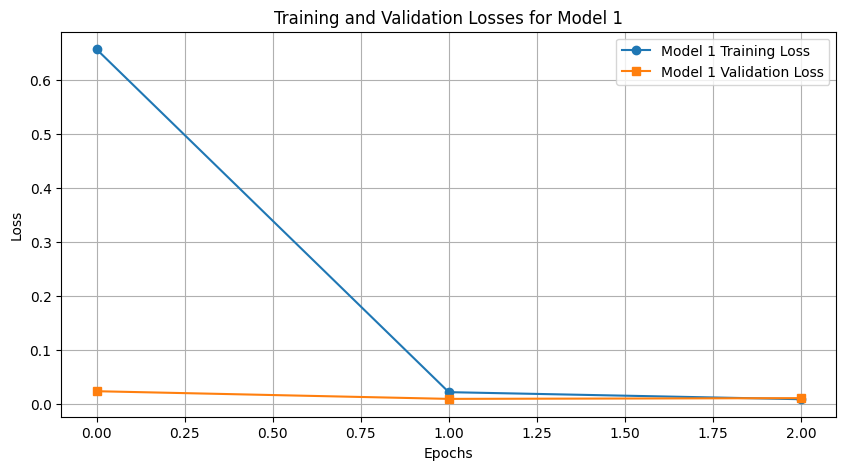

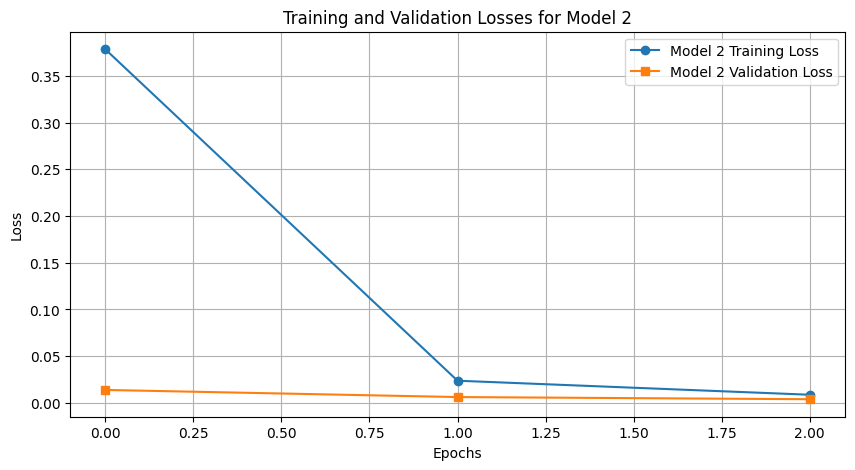

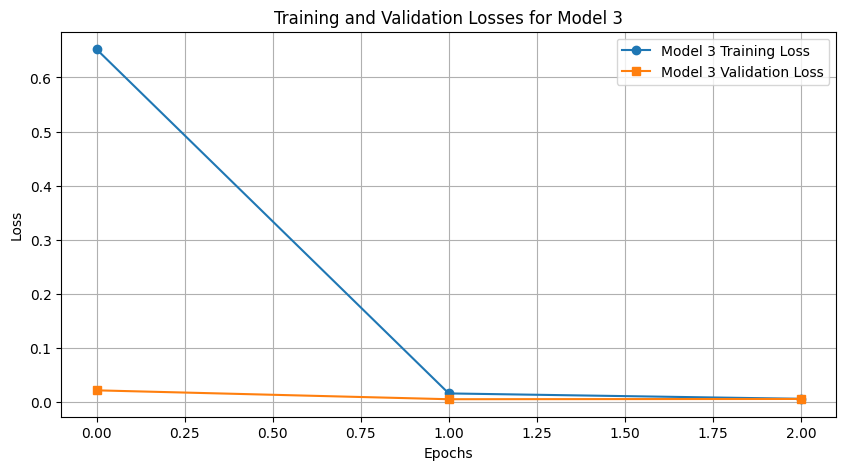

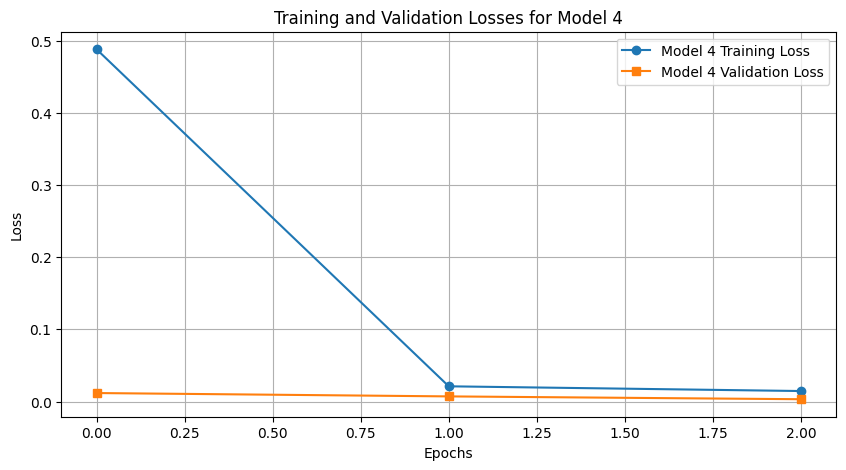

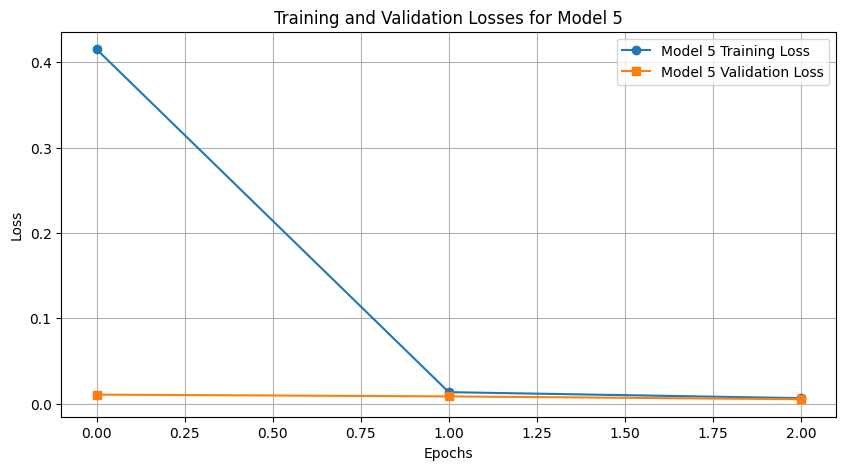

In [13]:
for i in range(len(models_list)):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses[i], label=f'Model {i+1} Training Loss', marker='o')
    plt.plot(val_losses[i], label=f'Model {i+1} Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Losses for Model {i+1}')
    plt.grid(True)
    plt.show()

**Results**

In [14]:
def evaluate_ensemble(models_list, test_loader, criterion, device, dataset_type, ensemble_method='mean'):

    all_preds = []
    all_labels = []
    running_loss = 0.0
    total = len(test_loader.dataset)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            all_labels.extend(labels.cpu().numpy())

            outputs = [model(images).to(device) for model in models_list]

            if ensemble_method == 'mean':
                avg_output = torch.mean(torch.stack(outputs), dim=0)
                _, predicted = torch.max(avg_output.data, 1)
                loss = criterion(avg_output,labels)

            elif ensemble_method == 'vote':
                votes = torch.stack([torch.argmax(output, dim=1) for output in outputs], dim=0)
                predicted = torch.mode(votes, dim=0).values
                loss = 0

            else:
                raise ValueError("Ensemble method must be 'mean' or 'vote'.")


            all_preds.extend(predicted.cpu().numpy())
            if ensemble_method == 'mean':
                running_loss += loss.item()


    avg_loss = running_loss / len(test_loader) if ensemble_method == 'mean' else 0
    correct = sum([pred == label for pred, label in zip(all_preds, all_labels)])
    accuracy = 100 * correct / total

    print(f"{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}")
    return avg_loss, accuracy


In [15]:
test_loss, test_accuracy = evaluate_ensemble(models_list, test_loader, criterion, device, dataset_type='Test')

Test Accuracy: 99.88% | Test Loss: 0.0033


In [16]:
def evaluate_and_confusion_matrix_for_models(models_list, test_loader, criterion, device, ensemble_method='mean'):


    for idx, model in enumerate(models_list):
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Model {idx + 1}')
        plt.show()


    if ensemble_method:
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = [model(images) for model in models_list]
                if ensemble_method == 'mean':  # میانگین‌گیری پیش‌بینی‌ها
                    avg_output = torch.mean(torch.stack(outputs), dim=0)
                    _, predicted = torch.max(avg_output.data, 1)
                elif ensemble_method == 'vote':  # رأی‌گیری اکثریت
                    votes = torch.stack([torch.argmax(output, dim=1) for output in outputs], dim=0)
                    predicted = torch.mode(votes, dim=0).values
                else:
                    raise ValueError("Ensemble method must be 'mean' or 'vote'.")

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())


        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
        disp.plot(cmap=plt.cm.Greens)
        plt.title(f'Confusion Matrix for Ensemble Model ({ensemble_method})')
        plt.show()


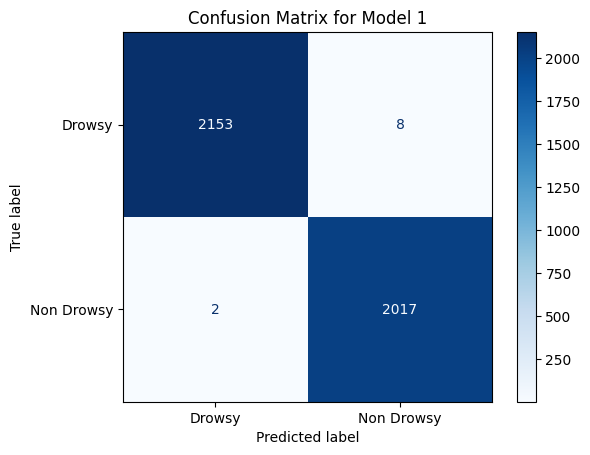

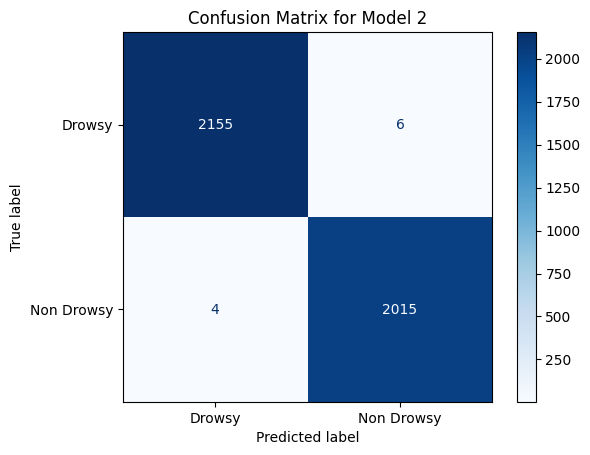

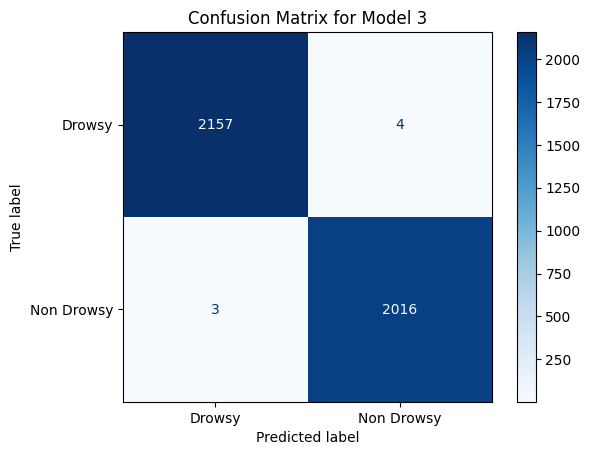

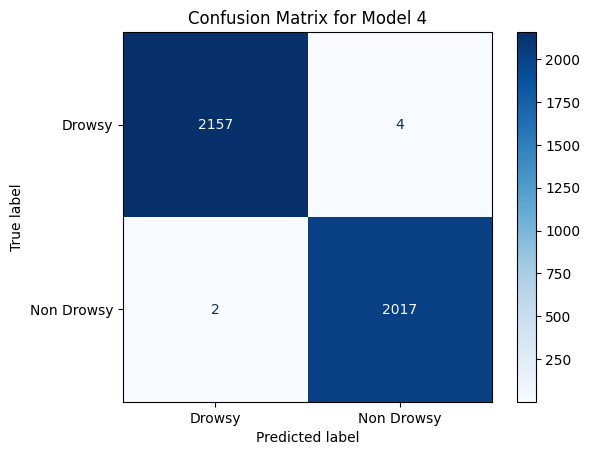

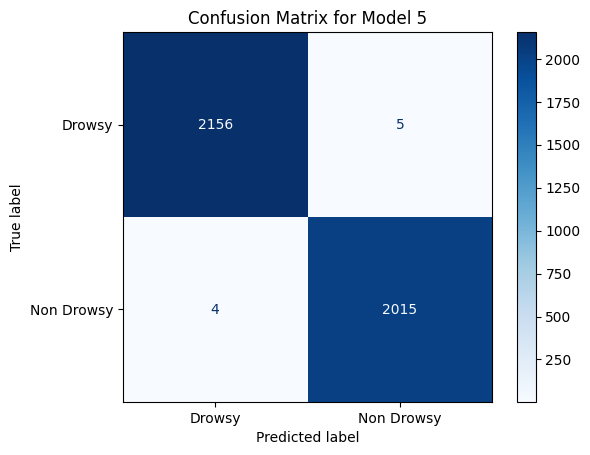

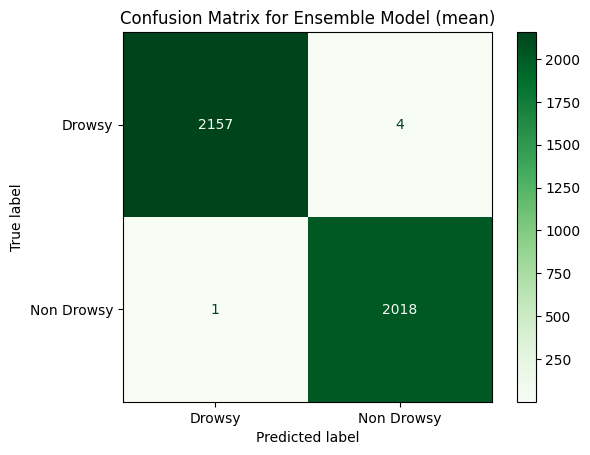

In [17]:
evaluate_and_confusion_matrix_for_models(models_list, test_loader, criterion, device)